# Gradient-weighted Class Activation Mapping (Grad-CAM)
> Use Grad-CAM to visualize where the network is looking at or which pixels in the image contribute most to the prediction being made

- toc: false 
- badges: true
- comments: false
- categories: [Grad-CAM, Gradient Heat map visualization, Image Classification, CIFAR-10, Cutout Augmentation]


 We will classify images in CIFAR 10 dataset and integrate Grad-CAM visualization. We will also use Cutout Image Augmentation for training the model

###Import necessary Modules 

In [ ]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

###create train and test data using cifar10 dataset in Keras 

In [ ]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


###Plot some of the images in the dataset along with class label

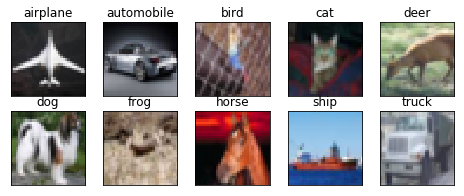

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

###Scale the input features to be within 0 and 1 
###convert the train and test labels to 10 class category format 

In [ ]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#### Define Model for image classification 

In [ ]:
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Activation,Flatten
# Define the model                                                              #RF
model = Sequential()

model.add(Conv2D(32, 3, border_mode='same', name='layer1', input_shape=(32, 32, 3)))           #3
model.add(BatchNormalization(name='BN1'))
model.add(Activation('relu',name='rl1'))

#Conv block 1 

model.add(Conv2D(64, 3,name='layer2',border_mode='same'))                                     #5
model.add(BatchNormalization(name='BN2'))
model.add(Activation('relu',name='rl2'))

model.add(Conv2D(128, 3,name='layer3'))                                                       #7
model.add(BatchNormalization(name='BN3'))
model.add(Activation('relu',name='rl3'))

#dropout after conv block1 
model.add(Dropout(0.1,name='drp1'))


#Transition Block 1
model.add(Conv2D(32,1,name='tb1'))
model.add(BatchNormalization(name='tb-BN1'))
model.add(Activation('relu',name='tb-rl1'))
model.add(MaxPooling2D(pool_size=(2, 2),name='mp1'))                                       #14

#Conv Block 2
model.add(Conv2D(64, 3, name='layer4',border_mode='same'))                                    #16  
model.add(BatchNormalization(name='BN4'))
model.add(Activation('relu',name='rl4'))
model.add(Conv2D(128, 3,name='layer5',border_mode='same'))                                    #18
model.add(BatchNormalization(name='BN5'))
model.add(Activation('relu',name='rl5'))


#dropout after conv block2 
model.add(Dropout(0.1,name='drp2'))

#Transition Block 2
model.add(Conv2D(32,1,name='tb2'))
model.add(BatchNormalization(name='tb-BN2'))
model.add(Activation('relu',name='tb-rl2'))
model.add(MaxPooling2D(pool_size=(2, 2),name='mp2'))                                       #36 - we have reached the image size here 

#final conv Block 

model.add(Conv2D(64, 3, name='layer6',border_mode='same'))                                    #38
model.add(BatchNormalization(name='BN6'))
model.add(Activation('relu',name='rl6'))
model.add(Conv2D(128, 3,name='layer7',border_mode='same'))                                    #40
model.add(BatchNormalization(name='BN7'))
model.add(Activation('relu',name='rl7'))

#dropout after final conv block
model.add(Dropout(0.1,name='d3'))

#Pointwise convolution to squash 128 channels to 10 output channels 
model.add(Conv2D(10,1,name='red1'))
model.add(BatchNormalization(name='red-BN1'))
model.add(Activation('relu',name='rrl1'))

#last conv layer - No ReLU activation, No Batch Normalization 
model.add(Conv2D(10,7,name='layer8'))                                                         #47

#Flatten the output 
model.add(Flatten())

#Softmax activation to output likelihood values for classes 

model.add(Activation('softmax'))

#Print model summary 

model.summary()



W0627 19:25:18.179095 139858174785408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, name="layer1", input_shape=(32, 32, 3..., padding="same")`
  """
W0627 19:25:18.194814 139858174785408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 19:25:18.197712 139858174785408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 19:25:18.224598 139858174785408 deprecation_wrapper.py:119] From /usr/local

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 32, 32, 32)        128       
_________________________________________________________________
rl1 (Activation)             (None, 32, 32, 32)        0         
_________________________________________________________________
layer2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
BN2 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
rl2 (Activation)             (None, 32, 32, 64)        0         
_________________________________________________________________
layer3 (Conv2D)              (None, 30, 30, 128)       73856     
__________

###Learning Rate Scheduler : We will add a custom learning rate scheduler that reduces the rate every 3rd epoch sugject to a min of 0.0005. We will also start with a slightly larger lr of 0.003 compared to default of 0.001 for Adam optimizer

In [ ]:
# define a learning rate scheduler . We will use a simple scheduler that reduces the lr by 10% every 3 epochs subject to a minimum lr of 0.0005 
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if (epoch%3==0 and epoch):
    new_lr = max(0.9*lr,0.0005) 
  else:
    new_lr=lr
  
  return round(new_lr, 10)
  
lr_scheduler=LearningRateScheduler(scheduler,verbose=1)



In [ ]:
#start with a higher lr of 0.003 
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

W0627 19:25:19.959195 139858174785408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



###mount google drive so that you can save the model with best validation accuracy and use it later for prediction tasks 

In [ ]:
from google.colab import drive

def mount_drive():
  drive.mount('/gdrive',force_remount=True)

mount_drive()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


### create a modelcheckpoint callback to chack validation accuracy at the end of each epoch and save the model with best validation accuracy 

In [ ]:
from keras.callbacks import ModelCheckpoint
  
chkpoint_model=ModelCheckpoint("/gdrive/My Drive/EVA/Session9/model_customv1_cifar10_best.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

### Data Augmentation : Define datagenerator with horizontal flip set to True ,zoom range of 0.15 . 

### Train the model for 100 epochs 


In [ ]:
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(zoom_range=0.15, 
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[chkpoint_model,lr_scheduler],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`
  
W0627 19:25:22.494500 139858174785408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 28s 73ms/step - loss: 1.3386 - acc: 0.5150 - val_loss: 2.5504 - val_acc: 0.3937

Epoch 00001: val_acc improved from -inf to 0.39370, saving model to /gdrive/My Drive/EVA/Session9/model_customv1_cifar10_best.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 24s 63ms/step - loss: 0.9163 - acc: 0.6763 - val_loss: 1.0819 - val_acc: 0.6341

Epoch 00002: val_acc improved from 0.39370 to 0.63410, saving model to /gdrive/My Drive/EVA/Session9/model_customv1_cifar10_best.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 25s 63ms/step - loss: 0.7828 - acc: 0.7260 - val_loss: 0.8384 - val_acc: 0.7091

Epoch 00003: val_acc improved from 0.63410 to 0.70910, saving model to /gdrive/My Drive/EVA/Session9/model_customv1_cifar10_bes

### Model trained for 100 epochs and reached a max validation accuracy of 88.05. Model with best validation accuracy was saved in google drive 

### load the model with best validation accuracy 

In [ ]:
from keras.models import load_model
model1=load_model('/gdrive/My Drive/EVA/Session9/model_customv1_cifar10_best.h5')

## Gradient-weighted Class Activation Mapping (Grad-CAM) : 
### Grad-CAM is a technique to visually represent where amodel is looking at and why it has made a certain prediction and was first present in this paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
### We will integrate Grad-CAM to visualize where the network is looking at or which pixels in the image contribute most to the prediction being made .

### Choose 4 images from the test dataset , predict their classes and print GradCam heatmap visualization for these 4 images 

 original class is :frog and predicted class is :frog


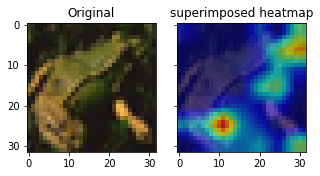

 original class is :horse and predicted class is :horse


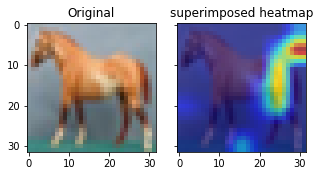

 original class is :truck and predicted class is :truck


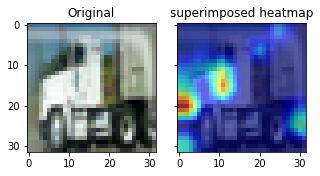

 original class is :cat and predicted class is :cat


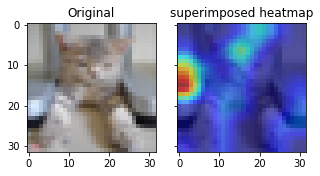

In [ ]:
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from google.colab.patches import cv2_imshow

#select test images and corresponding labels to print heatmap 
x=np.array([test_features[41],test_features[410],test_features[222],test_features[950]])
y=[test_labels[41],test_labels[410],test_labels[222],test_labels[950]]

#make prediction for these 4 images 
preds = model1.predict(x)
for j in range(4):
  #get class id from the prediction values 
  class_idx = np.argmax(preds[j])

  class_output = model1.output[:, class_idx]
  
  ## choose the layer before last 7x7 layer 
  last_conv_layer = model1.get_layer("rrl1")
  
  # compute gradients and from it heatmap 
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)  
  
  img = x[j]
  #resize heatmap 7x7 to image size of 32x32 
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  # convert from BGR to RGB 
  heatmap1 = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
  # create superimposed image if we want to print using cv2 (cv2_imshow supported in colab)
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.2, 0,dtype=5)
  
  
  # since cv.imshow does not work in jupyter notebooks and colab 
  # we will use matplotlib to print the image and its heatmap 
  fig = plt.figure(1, (5,5))

  grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1,2),  
                 axes_pad=0.3,  
                 )
  print(" original class is :"+class_names[np.argmax(y[j])]+" and predicted class is :"+str(class_names[class_idx]))
  grid[0].imshow(img)
  grid[0].set_title('Original')
  
  #print the original image and on top of it place the heat map at 70% transparency 
  grid[1].imshow(img,alpha=1)
  grid[1].imshow(heatmap1,alpha=0.7)
  grid[1].set_title('superimposed heatmap')
  
  plt.show()
  

## How about Misclassified Images ?

### Let us also choose 4 misclassified images to visualize their Grad-CAM heatmap 

In [ ]:
pred=model1.predict(test_features)
pred2=np.argmax(pred,axis=1)
wrong_set=[]
correct_set=[]
wrong_labels=[]
true_labels=[]
wrong_indices=[]
for i in range(10000):
  
  if (pred2[i]==np.argmax(test_labels[i])):
    
    correct_set.append(test_features[i])
  else:
    wrong_indices.append(i)
    wrong_labels.append(class_names[pred2[i]])
    true_labels.append(class_names[np.argmax(test_labels[i])])
    wrong_set.append(test_features[i])

### A selection of 4 misclassiifed images 

            Selection of 4 misclassified images 
           _________________________________



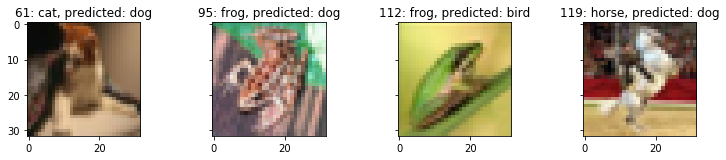

In [ ]:
print('            Selection of 4 misclassified images \n           _________________________________\n')
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(1, (12, 12))

grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 4),  
                 axes_pad=1,  
                 )
for i in range(5,9):
    
    grid[i-5].imshow(wrong_set[i].reshape(32,32,3))
    grid[i-5].set_title('{2}: {0}, predicted: {1}'.format(true_labels[i],wrong_labels[i],wrong_indices[i]))
    
plt.show()

### print Grad-CAM heatmap for the misclassifed images 

 original class is :cat and predicted class is :dog


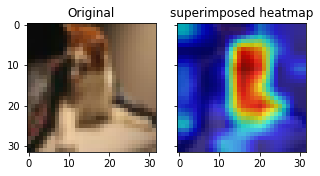

 original class is :frog and predicted class is :dog


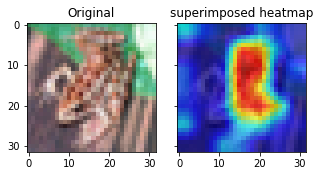

 original class is :frog and predicted class is :bird


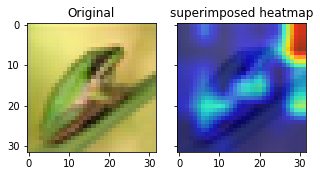

 original class is :horse and predicted class is :dog


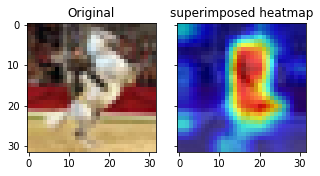

In [ ]:
#select the 4 of the misclassified images to be visualized 
w_list=wrong_indices[5:9]
x=[]
y=[]
for i in range(len(w_list)):
  x.append(test_features[w_list[i]])
  y.append(test_labels[w_list[i]])
  
#convert the image list to numpy array   
x=np.array(x)

#make prediction for these 4 images
preds = model1.predict(x)
for j in range(len(x)):
  #get class id from the prediction values 
  class_idx = np.argmax(preds[j])

  class_output = model1.output[:, class_idx]
  
  ## choose the layer before last 7x7 layer 
  last_conv_layer = model1.get_layer("rrl1")
  
  # compute gradients and from it heatmap
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)  
  
  img = x[j]
  #resize heatmap 7x7 to image size of 32x32 
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  # convert from BGR to RGB 
  heatmap1 = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
  # create superimposed image if we want to print using cv2 (cv2_imshow supported in colab)
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.2, 0,dtype=5)
  
  
  # since cv.imshow does not work in jupyter notebooks and colab 
  # we will use matplotlib to print the image and its heatmap 
  fig = plt.figure(1, (5,5))

  grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1,2),  
                 axes_pad=0.3,  
                 )
  print(" original class is :"+class_names[np.argmax(y[j])]+" and predicted class is :"+str(class_names[class_idx]))
  grid[0].imshow(img)
  grid[0].set_title('Original')
  
  
  #print the original image and on top of it place the heat map at 70% transparency   
  grid[1].imshow(img,alpha=1)
  grid[1].imshow(heatmap1,alpha=0.7)
  
  grid[1].set_title('superimposed heatmap')
  plt.show()

### We trained the model with some basic data augmentation techniques available in Keras and visualized the Grad-CAM heatmaps for a selection 4 correctly classified images and 4 misclassifed images . Let us now use another augmentation technique called cutout to train the model and see if it improves the prediction of these misclassified images and also visualize where the model looks at when making the prediction 

## Cutout Augmentation 
Cutout was first presented as an effective augmentation technique in these two papers :

[Improved Regularization of Convolutional Neural Networks with Cutout](https://arxiv.org/abs/1708.04552) 
and 
[Random Erasing Data Augmentation](https://arxiv.org/abs/1708.04896)

The idea is to randomly cut away patches of information from images that a model is training on to force it to learn from more parts of the image. This would help the model learn more features about a class instead of depending on some simple assumptions using smaller areas within the image . This helps the model generalize better and make better predictions . 

We will use python code for cutout /random erasing found at https://github.com/yu4u/cutout-random-erasing


In [ ]:
#get code for random erasing from https://github.com/yu4u/cutout-random-erasing
!wget https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py

--2019-06-27 20:06:44--  https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888 [text/plain]
Saving to: ‘random_eraser.py.2’

random_eraser.py.2  100%[===================>]     888  --.-KB/s    in 0s      

2019-06-27 20:06:45 (170 MB/s) - ‘random_eraser.py.2’ saved [888/888]



### define model (It is the same as above)

In [ ]:
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Activation,Flatten
# Define the model                                                              #RF
model = Sequential()

model.add(Conv2D(32, 3, border_mode='same', name='layer1', input_shape=(32, 32, 3)))           #3
model.add(BatchNormalization(name='BN1'))
model.add(Activation('relu',name='rl1'))

#Conv block 1 

model.add(Conv2D(64, 3,name='layer2',border_mode='same'))                                     #5
model.add(BatchNormalization(name='BN2'))
model.add(Activation('relu',name='rl2'))

model.add(Conv2D(128, 3,name='layer3'))                                                       #7
model.add(BatchNormalization(name='BN3'))
model.add(Activation('relu',name='rl3'))

#dropout after conv block1 
model.add(Dropout(0.1,name='drp1'))


#Transition Block 1
model.add(Conv2D(32,1,name='tb1'))
model.add(BatchNormalization(name='tb-BN1'))
model.add(Activation('relu',name='tb-rl1'))
model.add(MaxPooling2D(pool_size=(2, 2),name='mp1'))                                       #14

#Conv Block 2
model.add(Conv2D(64, 3, name='layer4',border_mode='same'))                                    #16  
model.add(BatchNormalization(name='BN4'))
model.add(Activation('relu',name='rl4'))
model.add(Conv2D(128, 3,name='layer5',border_mode='same'))                                    #18
model.add(BatchNormalization(name='BN5'))
model.add(Activation('relu',name='rl5'))


#dropout after conv block2 
model.add(Dropout(0.1,name='drp2'))

#Transition Block 2
model.add(Conv2D(32,1,name='tb2'))
model.add(BatchNormalization(name='tb-BN2'))
model.add(Activation('relu',name='tb-rl2'))
model.add(MaxPooling2D(pool_size=(2, 2),name='mp2'))                                       #36 - we have reached the image size here 

#final conv Block 

model.add(Conv2D(64, 3, name='layer6',border_mode='same'))                                    #38
model.add(BatchNormalization(name='BN6'))
model.add(Activation('relu',name='rl6'))
model.add(Conv2D(128, 3,name='layer7',border_mode='same'))                                    #40
model.add(BatchNormalization(name='BN7'))
model.add(Activation('relu',name='rl7'))

#dropout after final conv block
model.add(Dropout(0.1,name='d3'))

#Pointwise convolution to squash 128 channels to 10 output channels 
model.add(Conv2D(10,1,name='red1'))
model.add(BatchNormalization(name='red-BN1'))
model.add(Activation('relu',name='rrl1'))

#last conv layer - No ReLU activation, No Batch Normalization 
model.add(Conv2D(10,7,name='layer8'))                                                         #47

#Flatten the output 
model.add(Flatten())

#Softmax activation to output likelihood values for classes 

model.add(Activation('softmax'))

#Print model summary 

model.summary()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, name="layer1", input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, name="layer2", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, name="layer4", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, 3, name="layer5", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, name="layer6", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 32, 32, 32)        128       
_________________________________________________________________
rl1 (Activation)             (None, 32, 32, 32)        0         
_________________________________________________________________
layer2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
BN2 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
rl2 (Activation)             (None, 32, 32, 64)        0         
_________________________________________________________________
layer3 (Conv2D)              (None, 30, 30, 128)       73856     
__________

### compile the model with Adam optimizer and initial learning rate of 0.003

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

### define a new modelcheckpoint to save this model trained with cutout augmentaion in a separate path on drive 

In [ ]:

  
chkpoint_model=ModelCheckpoint("/gdrive/My Drive/EVA/Session9/model3_with_cutout_cifar10_best.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

### Data Augmentation : Define datagenerator with horizontal flip set to True ,zoom range of 0.15 .  
### Add random erasing or cutout as a preprocessing step . Use the default parameters from the random eraser code 

### train the model for 100 epochs 



In [ ]:
from random_eraser import get_random_eraser
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                             zoom_range=0.15, 
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[chkpoint_model,lr_scheduler],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`
  app.launch_new_instance()


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 29s 75ms/step - loss: 1.5322 - acc: 0.4402 - val_loss: 3.3519 - val_acc: 0.2329

Epoch 00001: val_acc improved from -inf to 0.23290, saving model to /gdrive/My Drive/EVA/Session9/model3_with_cutout_cifar10_best.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 26s 66ms/step - loss: 1.1131 - acc: 0.6023 - val_loss: 1.5691 - val_acc: 0.5297

Epoch 00002: val_acc improved from 0.23290 to 0.52970, saving model to /gdrive/My Drive/EVA/Session9/model3_with_cutout_cifar10_best.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 26s 66ms/step - loss: 0.9333 - acc: 0.6715 - val_loss: 0.9520 - val_acc: 0.6649

Epoch 00003: val_acc improved from 0.52970 to 0.66490, saving model to /gdrive/My Drive/EVA/Session9/model3_with_cutout

### load the new model trained with cutout augmentation 

In [ ]:
model1=load_model('/gdrive/My Drive/EVA/Session9/model3_with_cutout_cifar10_best.h5')

### visualize the same 4 images using Grad-CAM heatmap 

 original class is :frog and predicted class is :frog


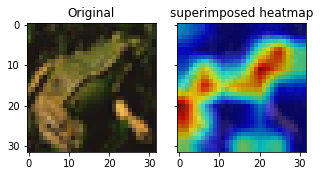

 original class is :horse and predicted class is :horse


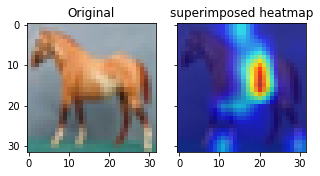

 original class is :truck and predicted class is :truck


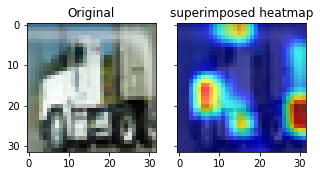

 original class is :cat and predicted class is :cat


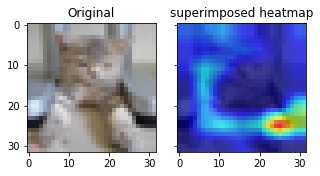

In [ ]:
#select test images and corresponding labels to print heatmap 
x=np.array([test_features[41],test_features[410],test_features[222],test_features[950]])
y=[test_labels[41],test_labels[410],test_labels[222],test_labels[950]]

#make prediction for these 4 images
preds = model1.predict(x)
for j in range(4):
  #get class id from the prediction values 
  class_idx = np.argmax(preds[j])

  class_output = model1.output[:, class_idx]
  
  ## choose the layer before last 7x7 layer 
  last_conv_layer = model1.get_layer("rrl1")
  
  # compute gradients and from it heatmap 
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)  
  
  img = x[j]
  #resize heatmap 7x7 to image size of 32x32 
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  # convert from BGR to RGB 
  heatmap1 = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
  # create superimposed image if we want to print using cv2 (cv2_imshow supported in colab)
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.2, 0,dtype=5)
  
  
  # since cv.imshow does not work in jupyter notebooks and colab 
  # we will use matplotlib to print the image and its heatmap 
  fig = plt.figure(1, (5,5))

  grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1,2),  
                 axes_pad=0.3,  
                 )
  print(" original class is :"+class_names[np.argmax(y[j])]+" and predicted class is :"+str(class_names[class_idx]))
  grid[0].imshow(img)
  grid[0].set_title('Original')
  
  #print the original image and on top of it place the heat map at 70% transparency 
  grid[1].imshow(img,alpha=1)
  grid[1].imshow(heatmap1,alpha=0.7)
  grid[1].set_title('superimposed heatmap')
  
  plt.show()
  
  

### Let us see what happened to the 4 misclassified images after cutout augmenation - if the prediction changed and if the heatmap pattern changed too 

 original class is :cat and predicted class is :cat


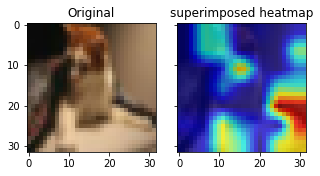

 original class is :frog and predicted class is :frog


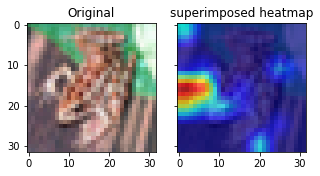

 original class is :frog and predicted class is :frog


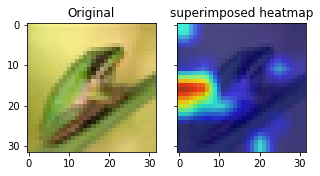

 original class is :horse and predicted class is :horse


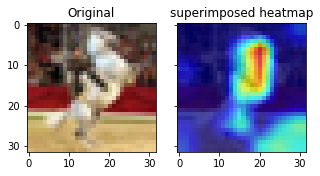

In [ ]:
#select the previously misclasified images to be visualized 
w_list=wrong_indices[5:9]
x=[]
y=[]
for i in range(len(w_list)):
  x.append(test_features[w_list[i]])
  y.append(test_labels[w_list[i]])
  
#convert the image list to numpy array   
x=np.array(x)

#make prediction for these 4 images
preds = model1.predict(x)
for j in range(len(x)):
  #get class id from the prediction values 
  class_idx = np.argmax(preds[j])

  class_output = model1.output[:, class_idx]
  
  ## choose the layer before last 7x7 layer 
  last_conv_layer = model1.get_layer("rrl1")
  
  # compute gradients and from it heatmap
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)  
  
  img = x[j]
  #resize heatmap 7x7 to image size of 32x32 
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  # convert from BGR to RGB 
  heatmap1 = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
  # create superimposed image if we want to print using cv2 (cv2_imshow supported in colab)
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.2, 0,dtype=5)
  
  
  # since cv.imshow does not work in jupyter notebooks and colab 
  # we will use matplotlib to print the image and its heatmap 
  fig = plt.figure(1, (5,5))

  grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1,2),  
                 axes_pad=0.3,  
                 )
  print(" original class is :"+class_names[np.argmax(y[j])]+" and predicted class is :"+str(class_names[class_idx]))
  grid[0].imshow(img)
  grid[0].set_title('Original')
  
  
  #print the original image and on top of it place the heat map at 70% transparency   
  grid[1].imshow(img,alpha=1)
  grid[1].imshow(heatmap1,alpha=0.7)
  
  grid[1].set_title('superimposed heatmap')
  plt.show()
 

### We can see that cutout augmenation forced the model to look at different parts of the image than it was looking at earlier and it helped in getting the classification of this set of 4 previously misclassified images right 

### It is also to be noted that the validation accuracy is still only at 88.28 even with cutout and we should train the network for more epochs and with different combinations of augmentations to get better results 